In [96]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTENC
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

from category_encoders import TargetEncoder
import category_encoders as ce

from sklearn import model_selection

from DFOneHot import DataFrameOneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [97]:
%%time
# train_values = pd.read_csv("train_values.csv", dtype ={'geo_level_1_id': str, 'geo_level_2_id': str, 'geo_level_3_id': str})
# train_labels = pd.read_csv("train_labels.csv")
# test_values = pd.read_csv("test_values.csv", dtype ={'geo_level_1_id': str, 'geo_level_2_id': str, 'geo_level_3_id': str})

train_values = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test_values = pd.read_csv("test_values.csv")

Wall time: 675 ms


In [98]:
# find number of rows and columns
print(
f'train_values shape: {train_values.shape}\n\
train_labels shape: {train_labels.shape}\n\
test_values shape: {test_values.shape}')

train_values shape: (260601, 39)
train_labels shape: (260601, 2)
test_values shape: (86868, 39)


In [99]:
test_values.shape

(86868, 39)

In [100]:
# # function to encode categorical features into numerical features to prepare for model fitting

# from sklearn.preprocessing import OneHotEncoder

# def prepare_inputs(X_train, X_test):
#     categ_col_train = X_train.select_dtypes(include=[object]).copy()
#     print(categ_col_train.columns)
#     categ_col_test = X_test.select_dtypes(include=[object]).copy()
#     ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
#     ohe.fit(categ_col_train)
    

#     categ_col_test.index = X_test.index
#     print(X_train.shape)
#     print(categ_col_train.shape)
#     enc_train_categ = pd.DataFrame(ohe.transform(categ_col_train))
#     enc_train_categ.index = X_train.index

#     X_train_enc = pd.concat([enc_train_categ, X_train.select_dtypes(exclude=[object])], axis=1)
    
#     print(f'left table: {enc_train_categ.shape}, right table: {X_train.select_dtypes(exclude=[object]).shape}\
# merged table: {X_train_enc.shape}')
    
#     enc_test_categ = pd.DataFrame(ohe.transform(categ_col_test))
#     enc_test_categ.index = X_test.index
#     X_test_enc = pd.concat([enc_test_categ, X_test.select_dtypes(exclude=[object])], axis=1)
   
#     print(f'left table: {enc_test_categ.shape}, right table: {X_test.select_dtypes(exclude=[object]).shape}\
# merged table: {X_test_enc.shape}')
#     return X_train_enc, X_test_enc

In [101]:
def target_encode_multiclass(X,y,cols): #X,y are pandas df and series, cols is a list of column variables
    y=y.astype(str)   #convert to string to onehot encode
    enc=ce.OneHotEncoder().fit(y)
    y_onehot=enc.transform(y)
    class_names=y_onehot.columns  #names of onehot encoded columns
#     X_obj=X.select_dtypes('object') #separate categorical columns
    X_col=X[cols].copy()
    for c in cols:
        X_col[c] = X_col[c].astype(str)
    X_rem=X[[x for x in X.columns if x not in cols]].copy() # remaining columns
    for class_ in class_names:
      
        enc=ce.TargetEncoder(smoothing=0.001)
        enc.fit(X_col,y_onehot[class_]) #convert all categorical 
        temp=enc.transform(X_col)       #columns for class_
        temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
        X_rem=pd.concat([X_rem,temp],axis=1)    #add to original dataset
    X_rem = pd.concat([X_rem, X[cols]], axis=1)  
    return X_rem

In [102]:
# possible values and distributions of the label
train_labels.damage_grade.value_counts()

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64

In [104]:
train_values.head(2)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0


# Splitting the Data

In [105]:
cols_to_drop = ['building_id']

In [106]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_values.drop(columns=cols_to_drop), train_labels['damage_grade'], test_size=0.2, random_state=42)

type(X_train)
type(y_train)

pandas.core.series.Series

In [107]:
X_train = target_encode_multiclass(X_train, y_train, ['geo_level_1_id', 'geo_level_2_id','geo_level_3_id'])

In [108]:
%%time
for col in ['geo_level_1_id', 'geo_level_2_id','geo_level_3_id']:
    uniq_v = X_test[col].unique()
    for v1 in uniq_v:
        for v2 in [1,2,3]:
            if v1 in X_train[col].unique():
                X_test.loc[X_test[col]==v1, f'{col}_damage_grade_{v2}'] = \
                    X_train.loc[(X_train[col]==v1),f'{col}_damage_grade_{v2}'].values[0]
            else:
                X_test.loc[X_test[col]==v1, f'{col}_damage_grade_{v2}'] = 0

Wall time: 2min 20s


In [58]:
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object')
(208480, 47)
(208480, 8)
left table: (208480, 38), right table: (208480, 39)merged table: (208480, 77)
left table: (52121, 38), right table: (52121, 30)merged table: (52121, 68)


In [109]:
X_train.shape

(208480, 47)

In [110]:
categ_col = []
for col in X_train.columns:
    if X_train[col].dtypes not in ('int64', 'float64'):
        categ_col.append(col)
#         print(train_values[col].value_counts(),'\n')
categ_col

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

In [111]:
transformer = ColumnTransformer(transformers=[('cat', DataFrameOneHotEncoder(handle_unknown='ignore'), categ_col)], 
                                remainder='passthrough')

In [211]:
%%time
pipe3 = Pipeline(steps=[("preprocessing", transformer),
                       ('xgb', XGBClassifier())],
               verbose=True)

pipe3.fit(X_train, y_train)
# print(df_ohe.fit_transform(train_values.head(3)))

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing xgb, total= 2.4min
Wall time: 2min 26s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  DataFrameOneHotEncoder(handle_unknown='ignore'),
                                                  ['land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration',
                                                   'legal_ownership_status'])])),
                ('xgb', XGBClassifier(objective='multi:softprob'))],
         verbose=True)

In [212]:
predictions = pipe3.predict(X_test)
f1_score(y_test, predictions, average='micro')

0.7348669442259357

In [188]:
%%time
pipe = Pipeline(steps=[("preprocessing", transformer),
                       ('xgb', XGBClassifier())],
               verbose=True)

# param_grid = {
#     'xgb__max_depth': range (2, 5, 1),      # originally (2, 10, 1)
#     'xgb__n_estimators': range(60, 220, 60), #            (60, 220, 40)
#     'xgb__learning_rate': [0.1, 0.01, 0.05]  #            (0.1, 0.01, 0.05)
# }

param_grid = {
    'xgb__max_depth': range (2, 10, 1),      # originally (2, 10, 1)
    'xgb__n_estimators': range(60, 220, 40), #            (60, 220, 40)
    'xgb__learning_rate': [0.1, 0.01, 0.05]  #            (0.1, 0.01, 0.05)
}

search = model_selection.GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, scoring='f1_micro', return_train_score=True, verbose=2)

search = search.fit(X_train, y_train)
# print(df_ohe.fit_transform(train_values.head(3)))

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing xgb, total= 9.3min
Wall time: 2h 52min 52s


In [201]:
search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  DataFrameOneHotEncoder(handle_unknown='ignore'),
                                                  ['land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration',
                                                   'legal_ownership_status'])])),
                ('xgb',
                 XGBClassifier(max_depth=8, n_estimators=180,
                               objective='multi:softprob'))],
         verbose=True)

In [204]:
y_train_pred = search.predict(X_train)
f1_score(y_train, y_train_pred, average='micro')

0.7862097083653108

In [191]:
y_pred = search.predict(X_test)
predictions = [round(value) for value in y_pred]
class_names = [str(x) for x in search.classes_]
print(classification_report(y_test, y_pred, target_names=class_names))
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score = {:.4f}".format(f1_score(y_test, predictions, average='micro')))

              precision    recall  f1-score   support

           1       0.67      0.55      0.60      5170
           2       0.75      0.84      0.79     29487
           3       0.75      0.64      0.69     17464

    accuracy                           0.74     52121
   macro avg       0.72      0.67      0.69     52121
weighted avg       0.74      0.74      0.74     52121

Accuracy: 74.19%
F1 Score = 0.7419


In [210]:
pipe['preprocessing'].transformers_[0][1]

DataFrameOneHotEncoder(handle_unknown='ignore')

In [179]:
ohe_col = pipe['preprocessing'].transformers_[0][1].column_names_
passthrough_col_i = np.array(pipe['preprocessing'].transformers_[1][2])
rem_col = list(X_train.columns[passthrough_col_i])
feature_names = [y for x in ohe_col for y in x] + rem_col
f_importance = pipe.named_steps['xgb'].feature_importances_

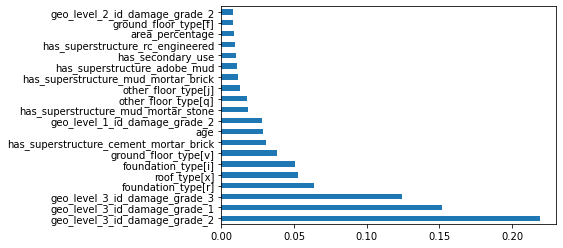

In [180]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(pipe.named_steps['xgb'].feature_importances_, index=feature_names)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


In [221]:
pipe = Pipeline(steps=[("preprocessing", transformer),
                       ('xgb', XGBClassifier(max_depth=8, n_estimators=180))],
               verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.9s
[Pipeline] ............... (step 2 of 2) Processing xgb, total=10.2min


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  DataFrameOneHotEncoder(handle_unknown='ignore'),
                                                  ['land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration',
                                                   'legal_ownership_status'])])),
                ('xgb',
                 XGBClassifier(max_depth=8, n_estimators=180,
                               objective='multi:softprob'))],
         verbose=True)

In [227]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(pipe, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

NameError: name 'boston' is not defined

In [243]:
len(sorted_idx)

47

In [238]:
len(np.array(feature_names))

77

Text(0.5, 0, 'Permutation Importance')

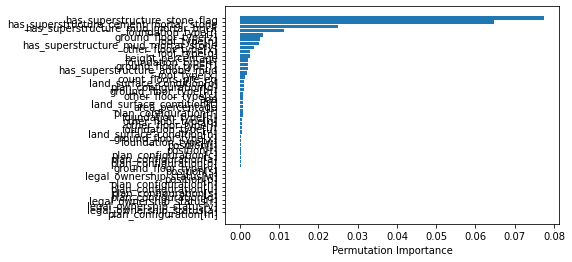

In [235]:
plt.barh(list(np.array(feature_names)[sorted_idx]), perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [242]:
pd.Series(feature_names)[sorted_idx]

28                     plan_configuration[m]
34                 legal_ownership_status[a]
36                 legal_ownership_status[v]
35                 legal_ownership_status[r]
31                     plan_configuration[q]
32                     plan_configuration[s]
33                     plan_configuration[u]
29                     plan_configuration[n]
21                               position[o]
37                 legal_ownership_status[w]
22                               position[s]
13                      ground_floor_type[v]
30                     plan_configuration[o]
24                     plan_configuration[a]
25                     plan_configuration[c]
23                               position[t]
20                               position[j]
7                         foundation_type[w]
14                      ground_floor_type[x]
0                  land_surface_condition[n]
6                         foundation_type[u]
16                       other_floor_type[j]
17        

In [241]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(pd.Series(feature_names)[sorted_idx])

TypeError: corr() missing 1 required positional argument: 'other'

# make prediction on official test data set

In [193]:
%%time
for col in ['geo_level_1_id', 'geo_level_2_id','geo_level_3_id']:
    uniq_v = test_values[col].unique()
    for v1 in uniq_v:
        for v2 in [1,2,3]:
            if v1 in X_train[col].unique():
                test_values.loc[test_values[col]==v1, f'{col}_damage_grade_{v2}'] = \
                    X_train.loc[(X_train[col]==v1),f'{col}_damage_grade_{v2}'].values[0]
            else:
                test_values.loc[test_values[col]==v1, f'{col}_damage_grade_{v2}'] = 0

Wall time: 2min 30s


In [194]:
y_pred_subm = search.predict(test_values)

In [197]:
submission_file = pd.DataFrame({'building_id':test_values.building_id, 'damage_grade':y_pred_subm})
submission_file

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [198]:
submission_file.to_csv('sibmission_file.csv', index=False)